In [1]:

import bokeh
import numpy as np
import pandas as pd
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import re
import seaborn as sns
from IPython.display import display
pd.options.mode.chained_assignment = None
import matplotlib
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
matplotlib.style.use('ggplot')

/home/sayali/anaconda3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
with open('./dataset-CalheirosMoroRita-2017.csv', encoding="iso-8859-1") as f:
    content = f.readlines()

In [3]:
content[1:10]

[' Everything from the weather, staff, food, property, fire pits, décor, spa, rooms and beach were top notch\n',
 '"The hotel it is fantastic built by the sea, living together with nature. Environment it is great as well as people and service.\n',
 'We full enjoyed the place, and facilities.\n',
 'Thanks for the ""cidreira"" and ""madalenas"" tea at reception"\n',
 'One dream! Cozy  and comfortable Hotel!  The best personalized one! All the employees are congratulated! Very nice taste, since reception to the end of the stay! We were welcome with tea and cake, as I have gluten aversion,, all the employees already knew and were waiting carefully. At night, we were received in the fire pits, with some wine and all the guests were invited to participate and interact. \n',
 '"Hotel concept is hard to grasp. They communicate environmental sustainability, through fashionable buzzwords like upcycling but they use pillows made out of duck feathers!?!\n',
 'Pricing is utterly ridiculous, for wha

In [4]:
data = pd.DataFrame(content[1:], columns=['Review'])

In [5]:
data.head()

,Review
0,"Everything from the weather, staff, food, pro..."
1,"""The hotel it is fantastic built by the sea, l..."
2,"We full enjoyed the place, and facilities.\n"
3,"Thanks for the """"cidreira"""" and """"madalenas"""" ..."
4,One dream! Cozy and comfortable Hotel! The b...


In [6]:
import nltk
import re
import string

from nltk.corpus import wordnet as wn
from contractions import CONTRACTION_MAP
from nltk.stem import WordNetLemmatizer
from html.parser import HTMLParser
import unicodedata

wnl = WordNetLemmatizer()
html_parser = HTMLParser()

stopword_list = nltk.corpus.stopwords.words('english')
stopword_list = stopword_list + ['mr', 'mrs', 'come', 'go', 'get',
                                 'tell', 'listen', 'one', 'two', 'three',
                                 'four', 'five', 'six', 'seven', 'eight',
                                 'nine', 'zero', 'join', 'find', 'make',
                                 'say', 'ask', 'tell', 'see', 'try', 'back',
                                 'also', '', None, ' ']

In [7]:
def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [8]:
   

def word_tokenize(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

In [9]:
def remove_special_characters(text):
    tokens = text
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub(' ', token) for token in tokens])
    return filtered_tokens
 

In [10]:
   
    
def remove_stopwords(text):
    tokens = text
    filtered_tokens = [token for token in tokens if token.strip() not in stopword_list]
    return filtered_tokens

In [11]:
def pos_tag_text(words):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
        
        
    def pos_tagging(words):
        return nltk.pos_tag(words)
    
    tagged_words = pos_tagging(words)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_words]
    return tagged_lower_text
    

In [12]:
def lemmatize_text(words):
    pos_tagged_words = pos_tag_text(words)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_words]
    return lemmatized_tokens


def normalize_corpus(line, lemmatize=True):
    
    line = html_parser.unescape(line)
    line = expand_contractions(line, CONTRACTION_MAP)
    
    words = word_tokenize(line)
    
    words = remove_special_characters(words)
    
    words = remove_stopwords(words)
    
    if lemmatize:
        words = lemmatize_text(words)
    return ' '.join(words)

In [13]:
data['Clean_Review'] = data.Review.apply(normalize_corpus)

/home/sayali/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


# Sentimental Analysis

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *

from nltk import tokenize

sid = SentimentIntensityAnalyzer()

In [15]:
data['sentiment_compound_polarity'] = data.Clean_Review.apply(lambda x:sid.polarity_scores(x)['compound'])
data['sentiment_neutral']=data.Clean_Review.apply(lambda x:sid.polarity_scores(x)['neu'])
data['sentiment_negative']=data.Clean_Review.apply(lambda x:sid.polarity_scores(x)['neg'])
data['sentiment_pos']=data.Clean_Review.apply(lambda x:sid.polarity_scores(x)['pos'])
data['sentiment_type']=''

In [16]:
data.loc[data.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
data.loc[data.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
data.loc[data.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'


In [17]:
data.head(10)

,Review,Clean_Review,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,"Everything from the weather, staff, food, pro...",everything weather staff food property fire pi...,-0.1531,0.724,0.158,0.118,NEGATIVE
1,"""The hotel it is fantastic built by the sea, l...",the hotel fantastic build sea live together na...,0.8689,0.505,0.000,0.495,POSITIVE
2,"We full enjoyed the place, and facilities.\n",we full enjoy place facility,0.4939,0.556,0.000,0.444,POSITIVE
3,"Thanks for the """"cidreira"""" and """"madalenas"""" ...",thanks cidreira madalenas tea reception,0.4404,0.580,0.000,0.420,POSITIVE
4,One dream! Cozy and comfortable Hotel! The b...,one dream cozy comfortable hotel the best pers...,0.9392,0.516,0.094,0.390,POSITIVE
5,"""Hotel concept is hard to grasp. They communic...",hotel concept hard grasp they communicate envi...,0.2732,0.794,0.074,0.132,POSITIVE
6,"Pricing is utterly ridiculous, for what you ge...",price utterly ridiculous,-0.4201,0.417,0.583,0.000,NEGATIVE
7,"Breakfast has high-quality products, but it la...",breakfast high quality product lack choice,-0.3182,0.685,0.315,0.000,NEGATIVE
8,"Service is friendly, although """"too friendly""""...",service friendly although friendly time,0.7506,0.319,0.000,0.681,POSITIVE
9,"Overall experience was ok, but you can get muc...",overall experience ok much well alternative lo...,0.2960,0.439,0.184,0.377,POSITIVE


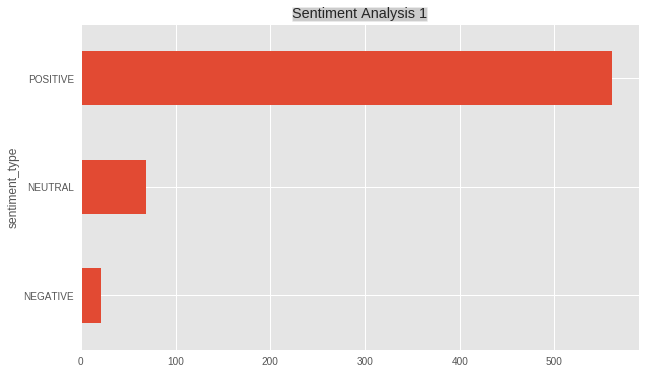

In [18]:
##matplotlib.style.use('ggplot')

review_sentiment = data.groupby(['sentiment_type'])['sentiment_neutral'].count()
review_sentiment.rename("",inplace=True)
explode = (0, 0, 1.0)
#plt.subplot(221)
review_sentiment.transpose().plot(kind='barh',figsize=(10, 6))
plt.title('Sentiment Analysis 1', bbox={'facecolor':'0.8', 'pad':0})


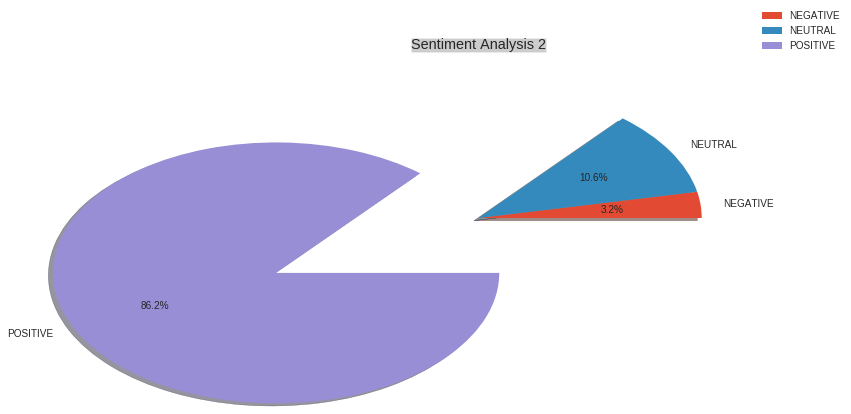

In [19]:
#plt.subplot(222)
review_sentiment.plot(kind='pie',figsize=(10, 6),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
plt.title('Sentiment Analysis 2', bbox={'facecolor':'0.8', 'pad':0})
plt.show()

# KeyWord Extraction

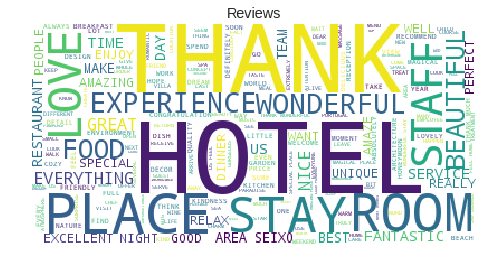

In [20]:
def wordcloud_by_province(data):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",
                          stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in data['Clean_Review'].str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Reviews")

wordcloud_by_province(data)  

##### We are using nltk.ne_chunk which returns a nested nltk.tree.Tree object so you would have to traverse the Tree object to get to the NEs.
We can use StanforNER or spacy for better results

In [21]:
def _NER(doc):
    tokenized_doc = nltk.word_tokenize(doc)

    # tag sentences and use nltk's Named Entity Chunker
    tagged_sentences = nltk.pos_tag(tokenized_doc)
    ne_chunked_sents = nltk.ne_chunk(tagged_sentences)

    # extract all named entities
    named_entities = []
    for tagged_tree in ne_chunked_sents:
        if hasattr(tagged_tree, 'label'):
            entity_name = ' '.join(c[0] for c in tagged_tree.leaves()) #
            entity_type = tagged_tree.label() # get NE category
            named_entities.append((entity_name, entity_type))
    return named_entities

data['NER_Class'] = data.Review.apply(_NER)
 

In [22]:
data['NER_Class']

0                                                     []
1                                                     []
2                                                     []
3                                                     []
4                                       [(Cozy, PERSON)]
5                                                     []
6                                       [(Pricing, GPE)]
7                                     [(Breakfast, GPE)]
8                                       [(Service, GPE)]
9                                       [(Overall, GPE)]
10                                                    []
11                                         [(Gold, GPE)]
12                             [(Room Mi Ma Bo, PERSON)]
13                   [(Land, GPE), (Room, ORGANIZATION)]
14                                                    []
15                                                    []
16                                                    []
17                      [(Areia

##### We can predict to which class named entity belongs to.

# topic modeling

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 300

We are currently using small number of feature here but greater number features will generate better result.

In [24]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data.Clean_Review)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [25]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(data.Clean_Review)
tf_feature_names = tf_vectorizer.get_feature_names()

In [26]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

/home/sayali/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [27]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [28]:
no_top_words = 10

## Topics from NMF are -

In [29]:
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
hotel world restaurant good short night paradise amaze comfortable garden
Topic 1:
thank amaze way joana make moment lovely want team anniversary
Topic 2:
place amazing magical feel sure service people décor relax nature
Topic 3:
wonderful people dream week wine expectation thank return night country
Topic 4:
love dream fantastic true kindness design recommend forever garden new
Topic 5:
thanks look team amaze moment wait lot everybody happy reception
Topic 6:
area seixo dear make moment like areias sure excellent architecture
Topic 7:
beautiful beach pleasant light welcome cozy food new walk delicious
Topic 8:
staff friendly food kind extremely kitchen amazing excellent helpful visit
Topic 9:
nice really people breakfast excellent delicious service weekend repeat restaurant
Topic 10:
experience repeat amaze unique excellent congratulation paradise doubt kindness magical
Topic 11:
time wait say service feel really come care night spend
Topic 12:
great breakfast dinner work dis

## Topics from LDA are 

In [30]:
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
dear amazing concrete décor truly love moment room wish friend
Topic 1:
wine guest employee receive year hotel come glass situation tub
Topic 2:
child experience stay home rest dream wonderful nature place nice
Topic 3:
kitchen high quality long taste flavor welcome leave help good
Topic 4:
different use fantastic pleasant booking site service present consider mention
Topic 5:
regard kind soon despite quality return spa enjoy day décor
Topic 6:
need order complaint think perfect miss want improve information bread
Topic 7:
wonderful experience seixo place make thank day stay room hotel
Topic 8:
thanks hope pass child year travel 10 enjoy world fabulous
Topic 9:
dinner stay great excellent dish wonderful long memory extraordinary star
Topic 10:
place great restaurant special feel beautiful amazing perfect time room
Topic 11:
happy family stay time natural memory helpful wonderful restaurant long
Topic 12:
good word kindness music far moment congratulation star wonderful big
Top

# To Be Continued .....

#### As a data science problem, we can always fine tune model with different values.
#### Here we can use more number of features or by reducing or increaing topics of data